In [1]:
import pandas as pd
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from nltk.corpus import stopwords
import re
import torch.nn.functional as F

# Define text cleaning function
def remove_ncw_trim(raw_text, additional_noncontent_words):
    # Replace periods with spaces
    raw_text = raw_text.replace('.', ' ')
    
    # Define English stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(additional_noncontent_words)  # Add custom non-content words

    # Remove sequences of 'x's or '*'s
    raw_text = re.sub(r'[x*]+', '', raw_text)
    raw_text = re.sub(r'[^A-Za-z\s]', '', raw_text)  # Remove non-alphabetic characters

    # Split and filter out stop words and non-content words
    uncut_words = raw_text.split()
    filtered_words = [word for word in uncut_words if word.lower() not in stop_words]

    return ' '.join(filtered_words)

# Load test data
test_data = pd.read_excel("Dataset/test_dataset.xlsx")

# Define non-content words
non_content = ['um', 'uh', 'mhm', 'mm', 'oh', 'customer', 'agent', 'says']

# Apply cleaning function to the text column
test_data['cleaned_text'] = test_data['text'].apply(lambda x: remove_ncw_trim(x, non_content))

# Initialize DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=57)
model_path = 'distilbert_model_v0.8_epoch4_vlr_m15.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Move model to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to predict labels and get top 10 logits
def predict_label(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        softmax_logits = F.softmax(logits, dim=1)
        top_10_logits, top_10_indices = torch.topk(softmax_logits, 10)
        predicted_label = top_10_indices[0, 0].item()
        return predicted_label, top_10_logits.cpu().numpy().tolist()[0]

# Applying predictions to the test data
test_data['predicted_label'], test_data['top_10_logits'] = zip(*test_data['cleaned_text'].apply(predict_label))

# Expand top 10 logits into separate columns
for i in range(10):
    test_data[f'logit_{i}'] = test_data['top_10_logits'].apply(lambda x: x[i])

# Drop the original 'top_10_logits' column
test_data.drop('top_10_logits', axis=1, inplace=True)

# Load label mapping
label_mapping = pd.read_csv('label_mapping.csv').set_index('Encoded')['Label'].to_dict()

# Apply label mapping
test_data['predicted_label_name'] = test_data['predicted_label'].map(label_mapping)

# Export to CSV
test_data.to_csv('test_data_predictions.csv', index=False)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# Calculating overall F1 Score and Accuracy
overall_f1 = f1_score(test_data['label'], test_data['predicted_label_name'], average='micro')
overall_accuracy = accuracy_score(test_data['label'], test_data['predicted_label_name'])

print(f"Overall F1 Score: {overall_f1}")
print(f"Overall Accuracy: {overall_accuracy}")

Overall F1 Score: 0.694997469208706
Overall Accuracy: 0.694997469208706


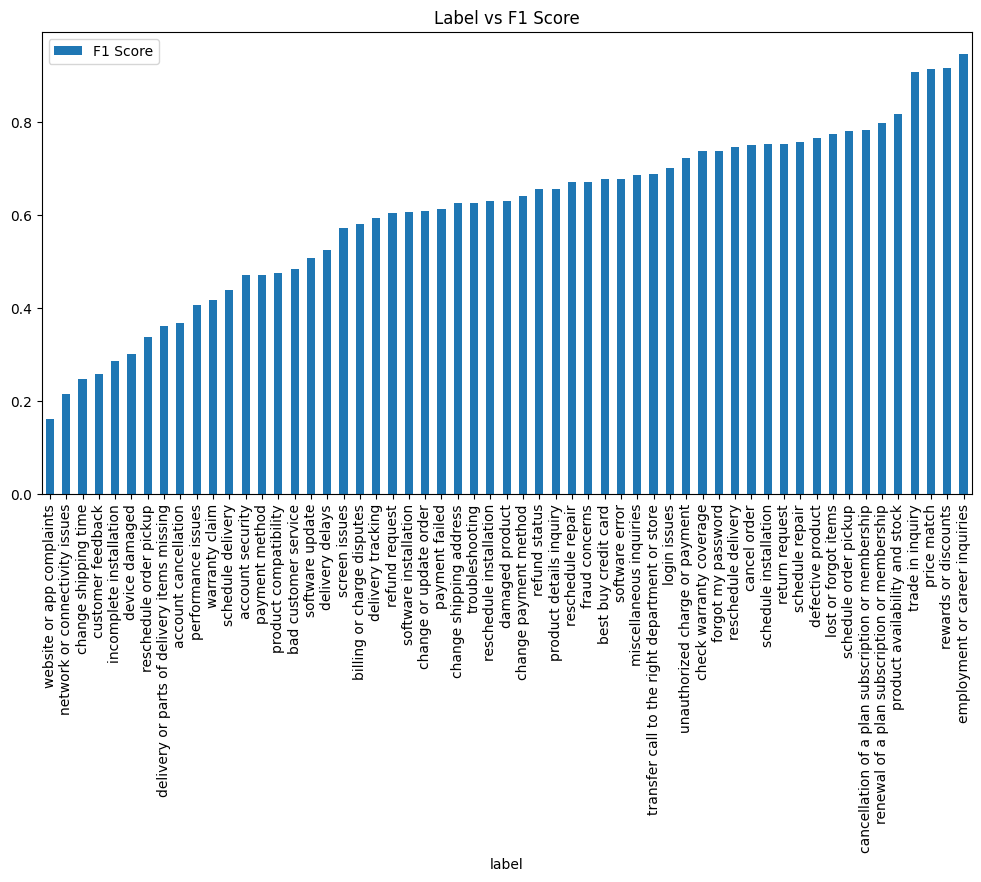

In [3]:
# Calculating label-wise F1 Score and Accuracy
label_wise_metrics = test_data.groupby('label').apply(
    lambda x: pd.Series({
        'F1 Score': f1_score(x['label'], x['predicted_label_name'], average='micro'),
        'Accuracy': accuracy_score(x['label'], x['predicted_label_name'])
    })
).reset_index()

# Sort label-wise metrics for plotting
label_wise_metrics = label_wise_metrics.sort_values(by='F1 Score')

# Plot label vs F1 score
label_wise_metrics.plot(x='label', y='F1 Score', kind='bar', figsize=(12, 6), title='Label vs F1 Score')
plt.show()



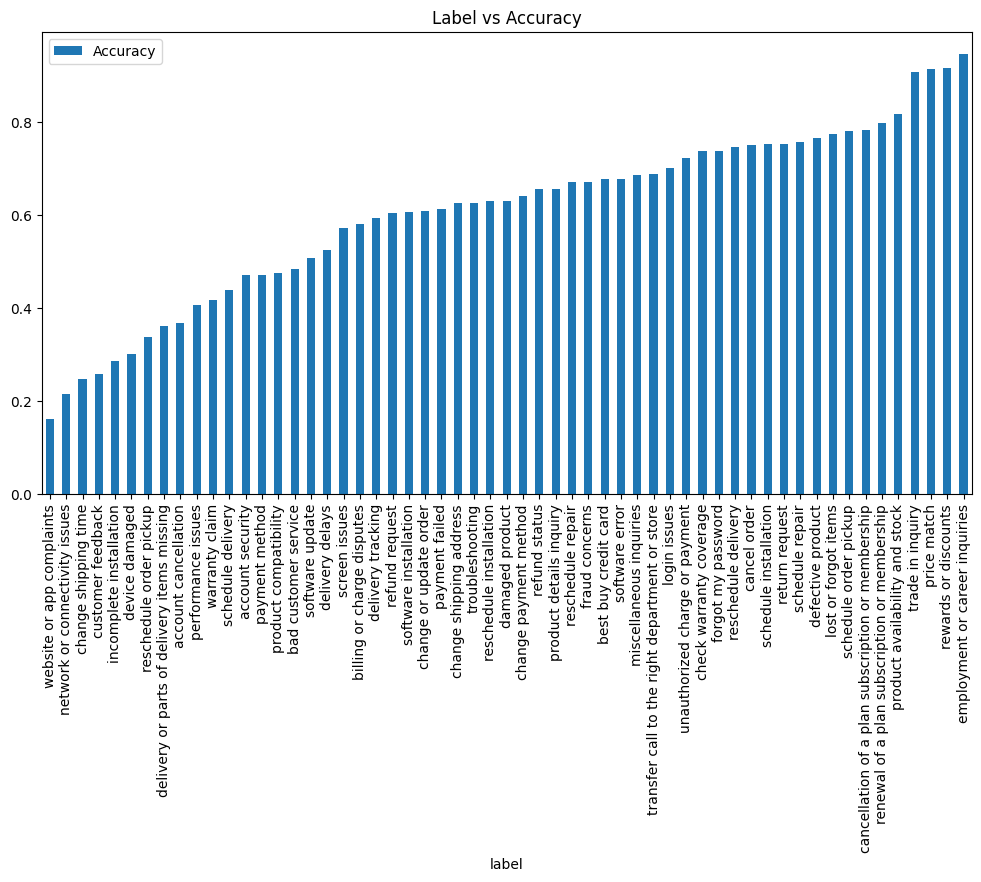

In [4]:
# Plot label vs Accuracy
label_wise_metrics.plot(x='label', y='Accuracy', kind='bar', figsize=(12, 6), title='Label vs Accuracy')
plt.show()

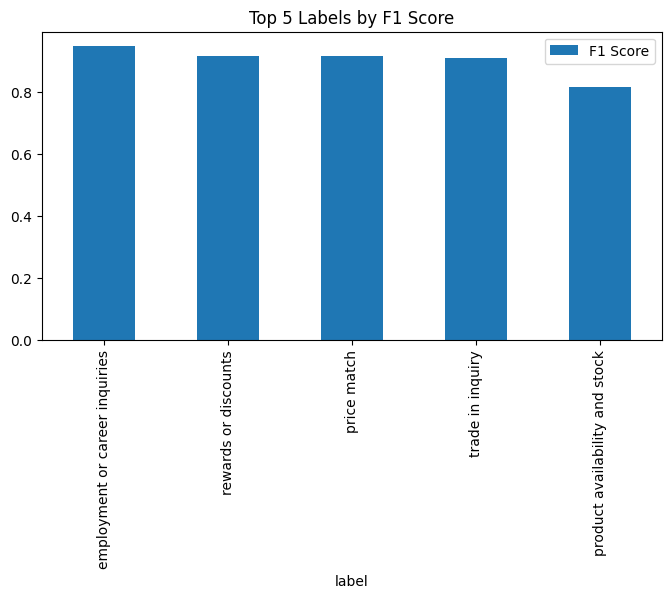

In [5]:
# Top 5 labels by F1 Score
top_5_f1 = label_wise_metrics.nlargest(5, 'F1 Score')
top_5_f1.plot(x='label', y='F1 Score', kind='bar', figsize=(8, 4), title='Top 5 Labels by F1 Score')
plt.show()


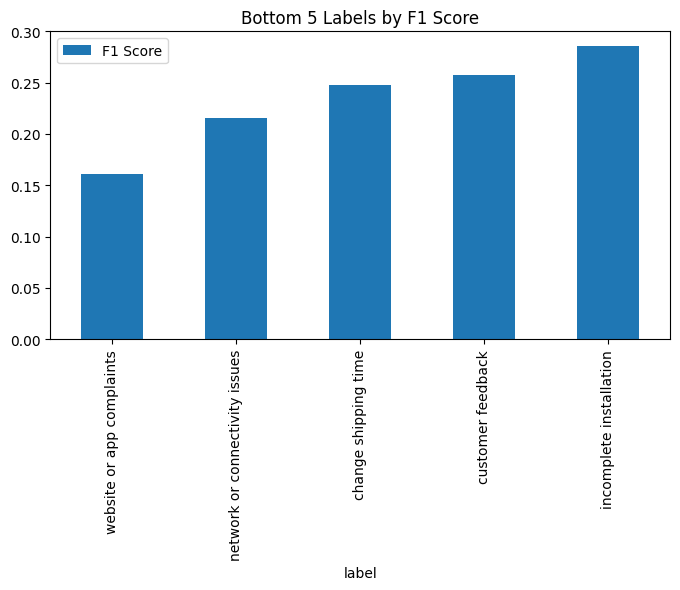

In [6]:
# Bottom 5 labels by F1 Score
bottom_5_f1 = label_wise_metrics.nsmallest(5, 'F1 Score')
bottom_5_f1.plot(x='label', y='F1 Score', kind='bar', figsize=(8, 4), title='Bottom 5 Labels by F1 Score')
plt.show()



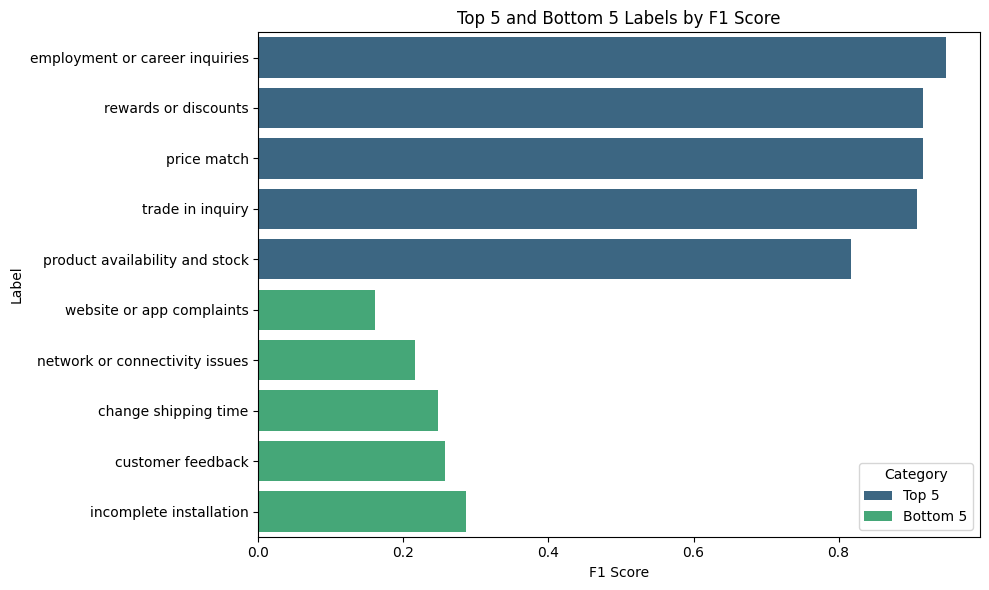

In [16]:
import seaborn as sns

# Top 5 labels by F1 Score
top_5_f1 = label_wise_metrics.nlargest(5, 'F1 Score')

# Bottom 5 labels by F1 Score
bottom_5_f1 = label_wise_metrics.nsmallest(5, 'F1 Score')

# Combine top 5 and bottom 5 into a single DataFrame
combined_f1 = pd.concat([top_5_f1, bottom_5_f1])

# Mark each row as either 'Top 5' or 'Bottom 5'
combined_f1['Category'] = ['Top 5' if label in top_5_f1['label'].values else 'Bottom 5' 
                           for label in combined_f1['label']]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_f1, y='label', x='F1 Score', hue='Category', palette='viridis', orient='h')
plt.title('Top 5 and Bottom 5 Labels by F1 Score')
plt.ylabel('Label')
plt.xlabel('F1 Score')
plt.legend(title='Category', loc='lower right')  # Move legend to bottom right
plt.tight_layout()
plt.show()

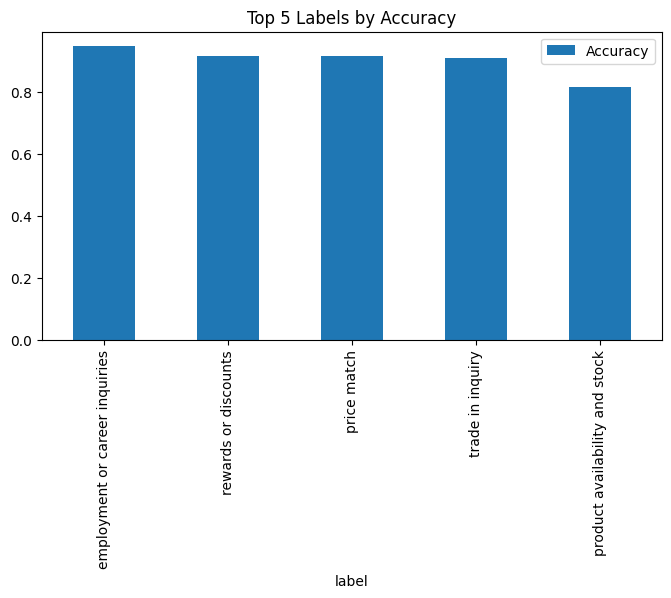

In [7]:
# Top 5 labels by Accuracy
top_5_accuracy = label_wise_metrics.nlargest(5, 'Accuracy')
top_5_accuracy.plot(x='label', y='Accuracy', kind='bar', figsize=(8, 4), title='Top 5 Labels by Accuracy')
plt.show()


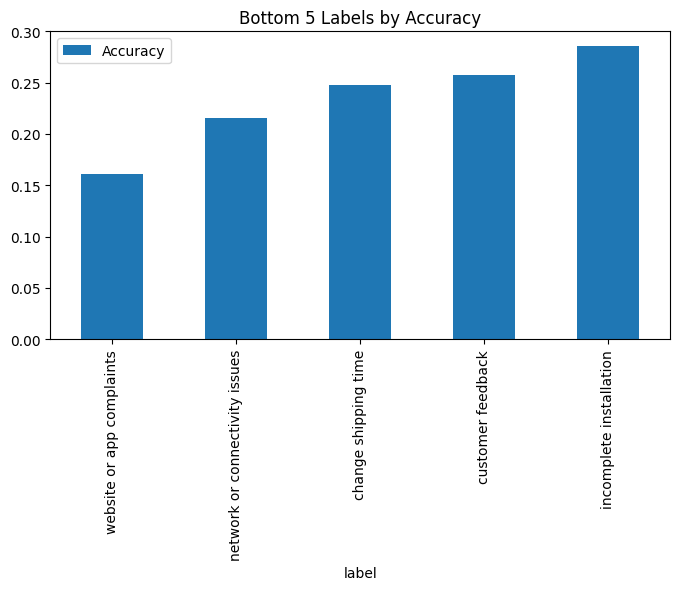

In [8]:
# Bottom 5 labels by Accuracy
bottom_5_accuracy = label_wise_metrics.nsmallest(5, 'Accuracy')
bottom_5_accuracy.plot(x='label', y='Accuracy', kind='bar', figsize=(8, 4), title='Bottom 5 Labels by Accuracy')
plt.show()

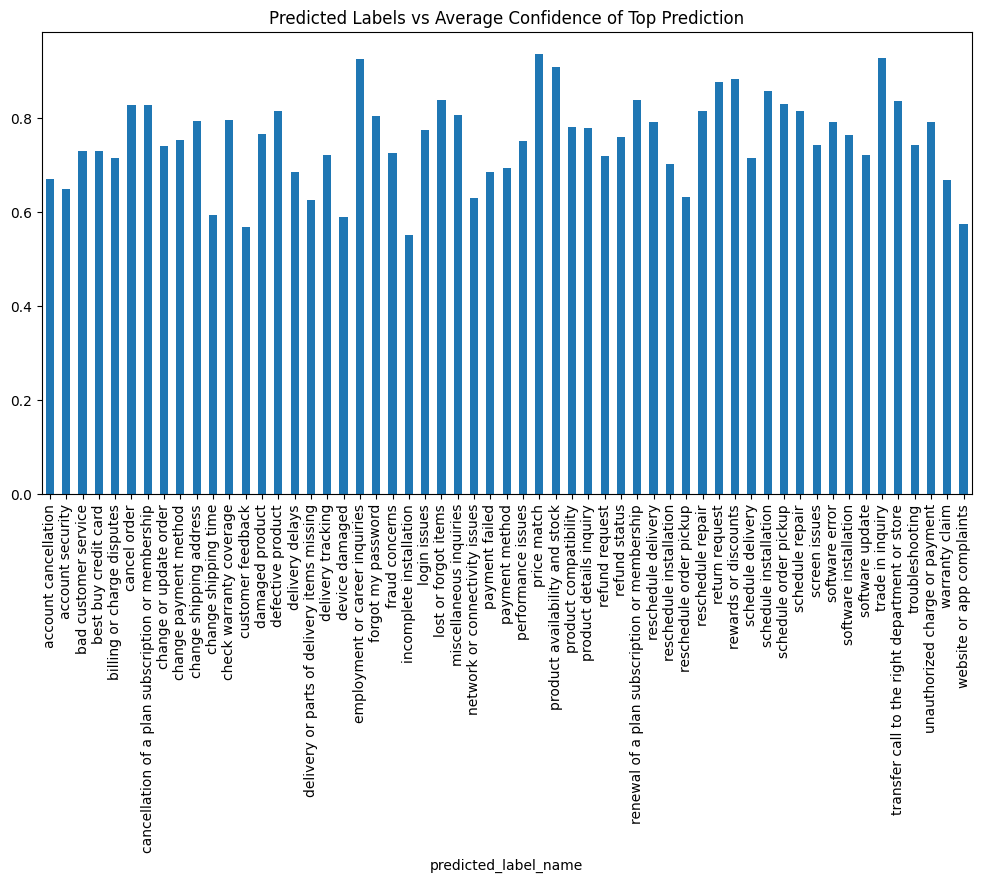

In [17]:
# Calculate the average of logit_0 for each predicted label
avg_logit_0_by_predicted_label = test_data.groupby('predicted_label_name')['logit_0'].mean()

# Sort the average logit_0 values for easy identification of top and bottom labels
sorted_avg_logit_0 = avg_logit_0_by_predicted_label.sort_values()

# Plot predicted labels vs average logit_0
avg_logit_0_by_predicted_label.plot(kind='bar', figsize=(12, 6), title='Predicted Labels vs Average Confidence of Top Prediction')
plt.show()



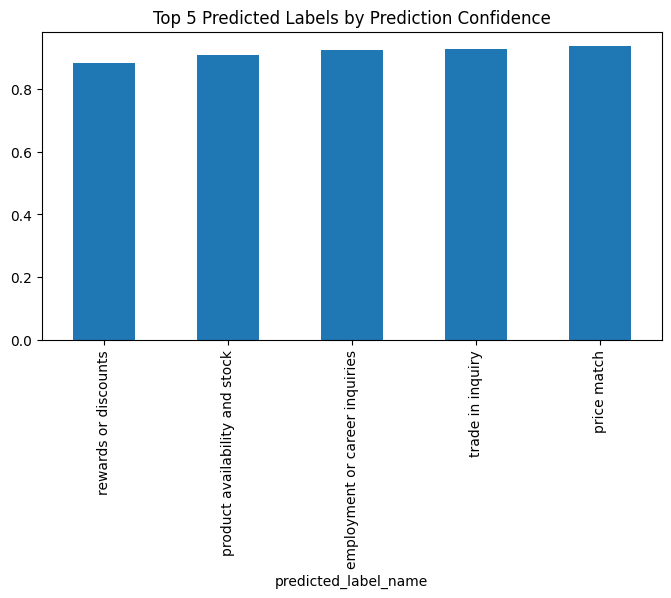

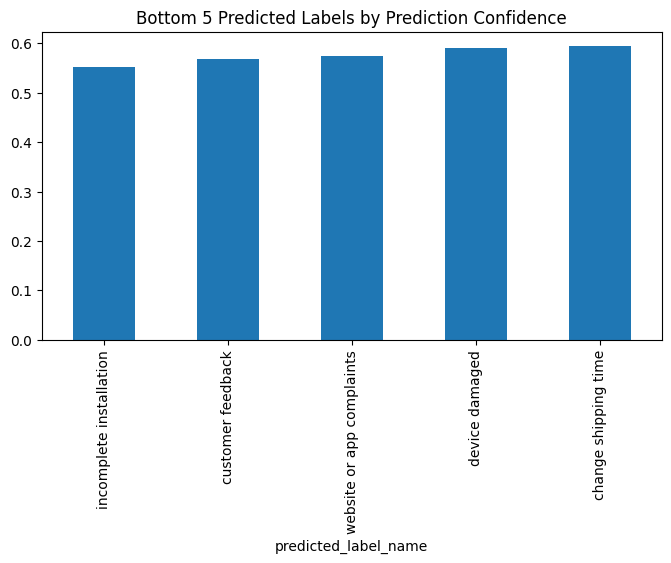

In [23]:
# Top 5 labels by average logit_0 confidence
top_5_logit_0 = sorted_avg_logit_0.tail(5)
top_5_logit_0.plot(kind='bar', figsize=(8, 4), title='Top 5 Predicted Labels by Prediction Confidence')
plt.show()

# Bottom 5 labels by average logit_0 confidence
bottom_5_logit_0 = sorted_avg_logit_0.head(5)
bottom_5_logit_0.plot(kind='bar', figsize=(8, 4), title='Bottom 5 Predicted Labels by Prediction Confidence')
plt.show()


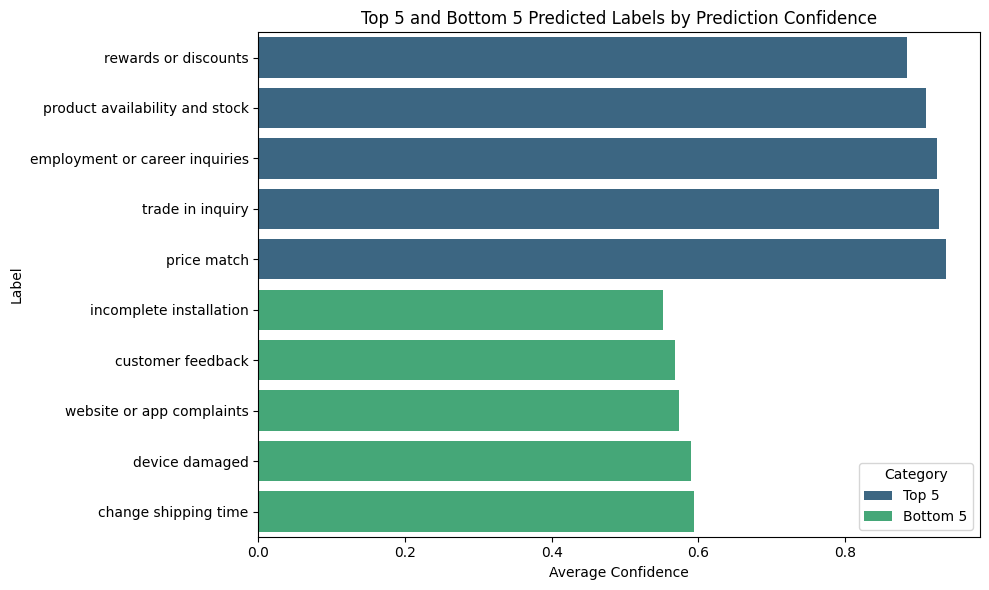

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sorted_avg_logit_0 is already defined and sorted based on average logit_0 confidence

# Top 5 labels by average logit_0 confidence
top_5_logit_0 = sorted_avg_logit_0.tail(5)

# Bottom 5 labels by average logit_0 confidence
bottom_5_logit_0 = sorted_avg_logit_0.head(5)

# Combine top 5 and bottom 5 into a single DataFrame and reset index
combined_logit_0 = pd.concat([top_5_logit_0, bottom_5_logit_0]).reset_index()
combined_logit_0.columns = ['Label', 'Logit_0']  # Explicitly setting column names

# Mark each row as either 'Top 5' or 'Bottom 5'
combined_logit_0['Category'] = ['Top 5' if label in top_5_logit_0.index else 'Bottom 5' 
                               for label in combined_logit_0['Label']]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_logit_0, y='Label', x='Logit_0', hue='Category', palette='viridis', orient='h')
plt.title('Top 5 and Bottom 5 Predicted Labels by Prediction Confidence')
plt.ylabel('Label')
plt.xlabel('Average Confidence')
plt.legend(title='Category', loc='lower right')
plt.tight_layout()
plt.show()


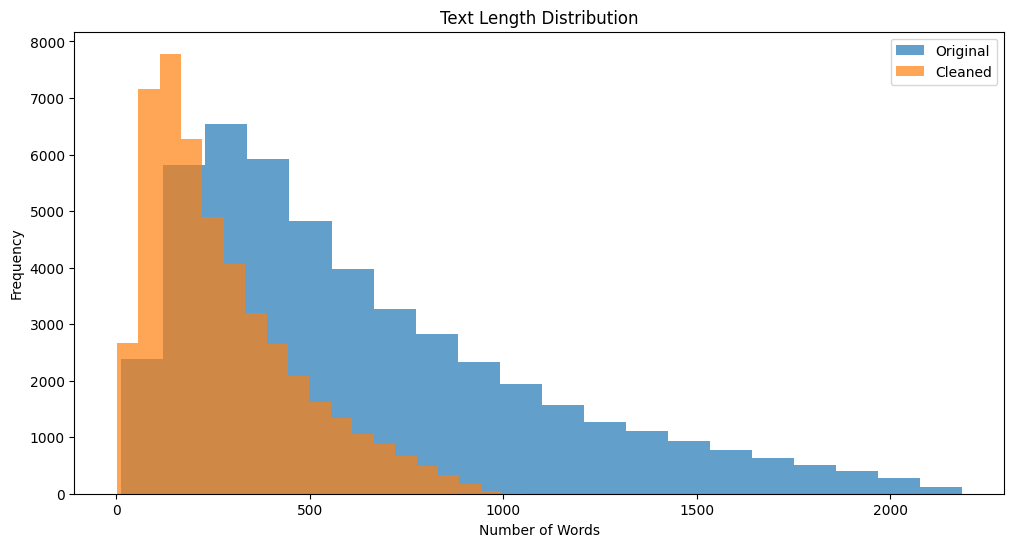

In [28]:
# text preprocessing visualizaton
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(test_data['text'].str.split().str.len(), bins=20, alpha=0.7, label='Original')
plt.hist(test_data['cleaned_text'].str.split().str.len(), bins=20, alpha=0.7, label='Cleaned')
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()


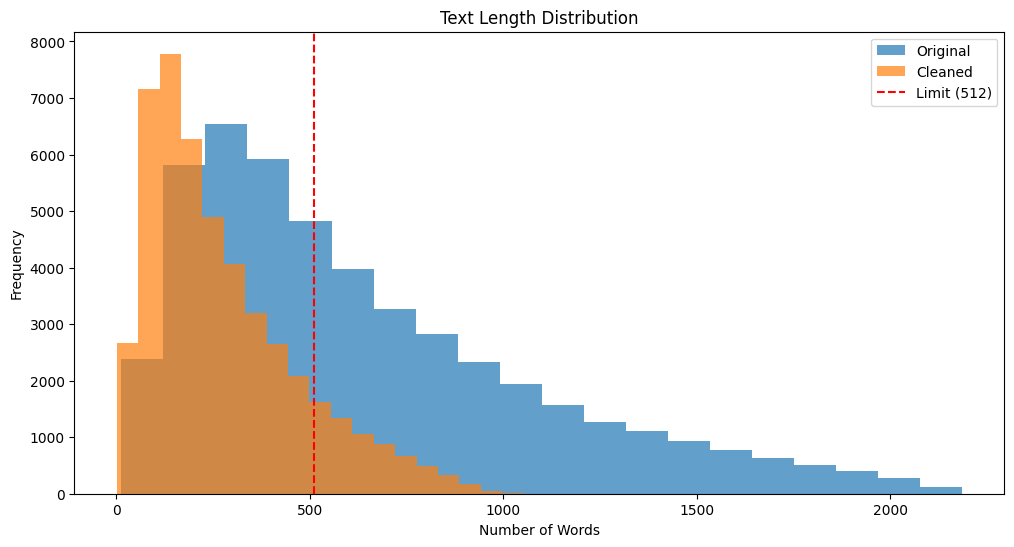

In [29]:
plt.figure(figsize=(12, 6))
plt.hist(test_data['text'].str.split().str.len(), bins=20, alpha=0.7, label='Original')
plt.hist(test_data['cleaned_text'].str.split().str.len(), bins=20, alpha=0.7, label='Cleaned')
plt.axvline(x=512, color='red', linestyle='--', label='Limit (512)')  # Add a vertical line at 512
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [30]:
# Function to calculate the percentage of texts above a certain word count threshold
def calculate_percentage_above_threshold(df, original_column, cleaned_column, threshold):
    total_texts = df.shape[0]
    above_threshold_original = df[df[original_column].str.split().str.len() > threshold].shape[0]
    above_threshold_cleaned = df[df[cleaned_column].str.split().str.len() > threshold].shape[0]

    percentage_above_threshold_original = (above_threshold_original / total_texts) * 100
    percentage_above_threshold_cleaned = (above_threshold_cleaned / total_texts) * 100

    return percentage_above_threshold_original, percentage_above_threshold_cleaned

# Apply the function to your dataset
threshold = 512
percentage_above_512_original, percentage_above_512_cleaned = calculate_percentage_above_threshold(test_data, 'text', 'cleaned_text', threshold)

# Print the results
print(f"Percentage of texts above {threshold} words before cleaning: {percentage_above_512_original:.2f}%")
print(f"Percentage of texts above {threshold} words after cleaning: {percentage_above_512_cleaned:.2f}%")



Percentage of texts above 512 words before cleaning: 50.00%
Percentage of texts above 512 words after cleaning: 13.02%


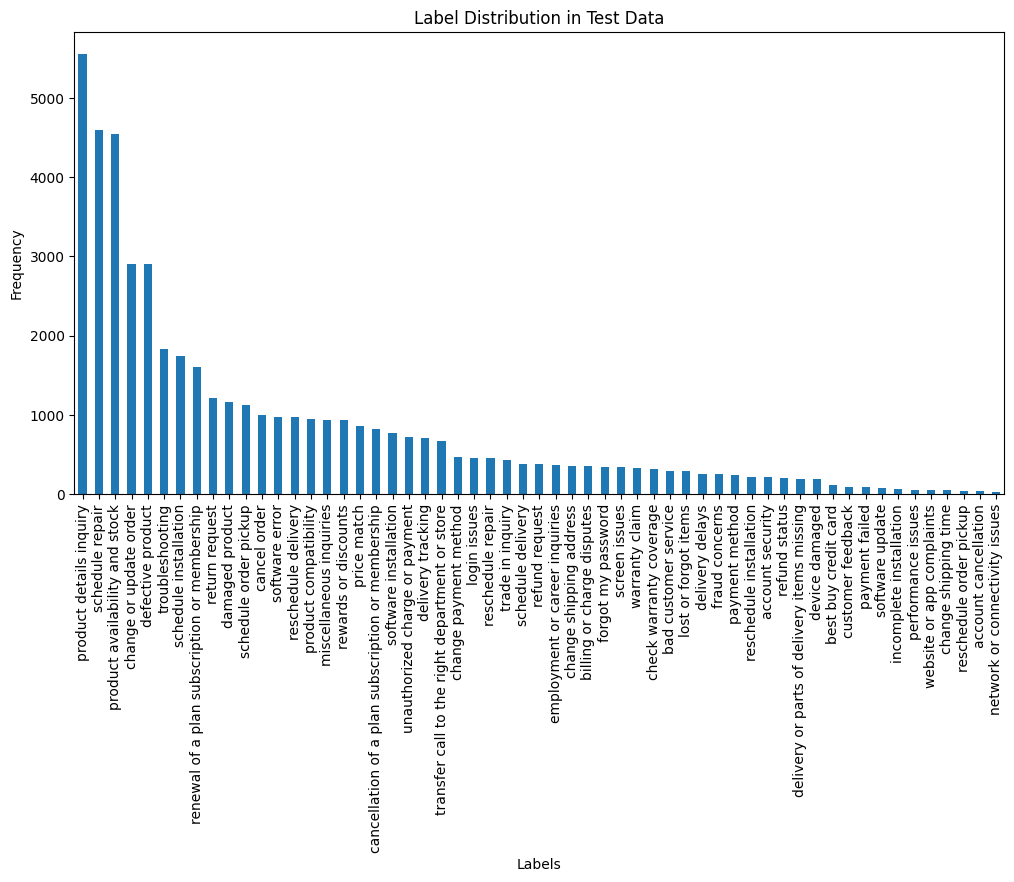

In [31]:
# Label Distribution

test_data['predicted_label_name'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Label Distribution in Test Data')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

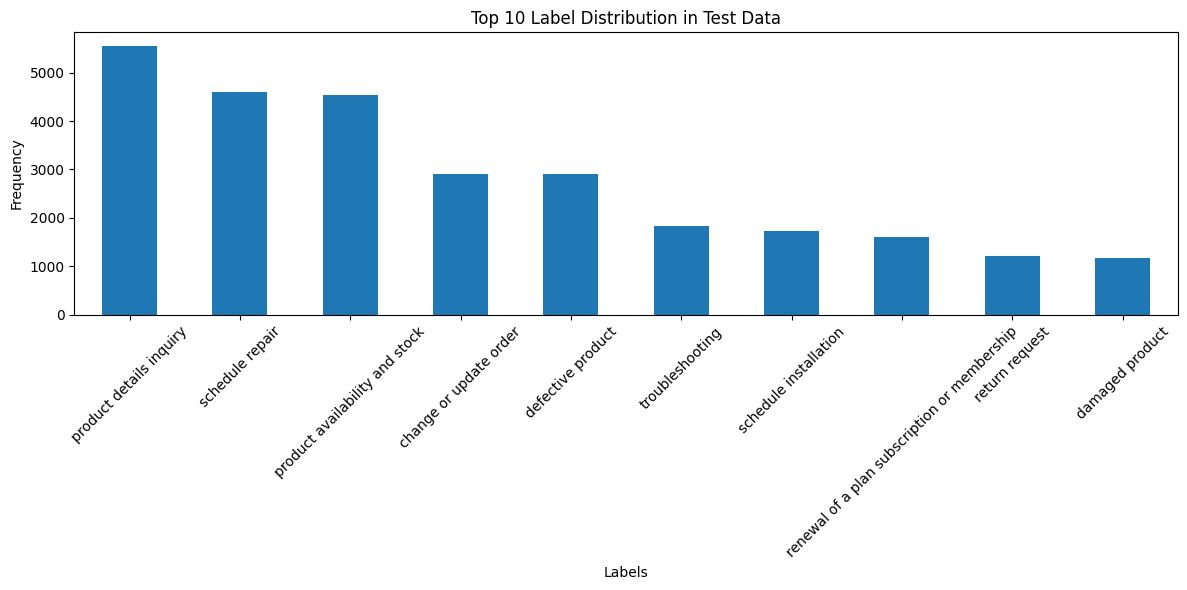

predicted_label_name
product details inquiry                         5554
schedule repair                                 4592
product availability and stock                  4546
change or update order                          2908
defective product                               2899
troubleshooting                                 1833
schedule installation                           1736
renewal of a plan subscription or membership    1601
return request                                  1210
damaged product                                 1162
Name: count, dtype: int64


In [32]:
# Define the number of top labels you want to display
top_n = 10

# Calculate the value counts and keep the top 'n' labels
label_counts = test_data['predicted_label_name'].value_counts().nlargest(top_n)

# Plotting the top 'n' label counts
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Top 10 Label Distribution in Test Data')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the labels for better readability if needed
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# If you want to print the labels and their counts
print(label_counts)

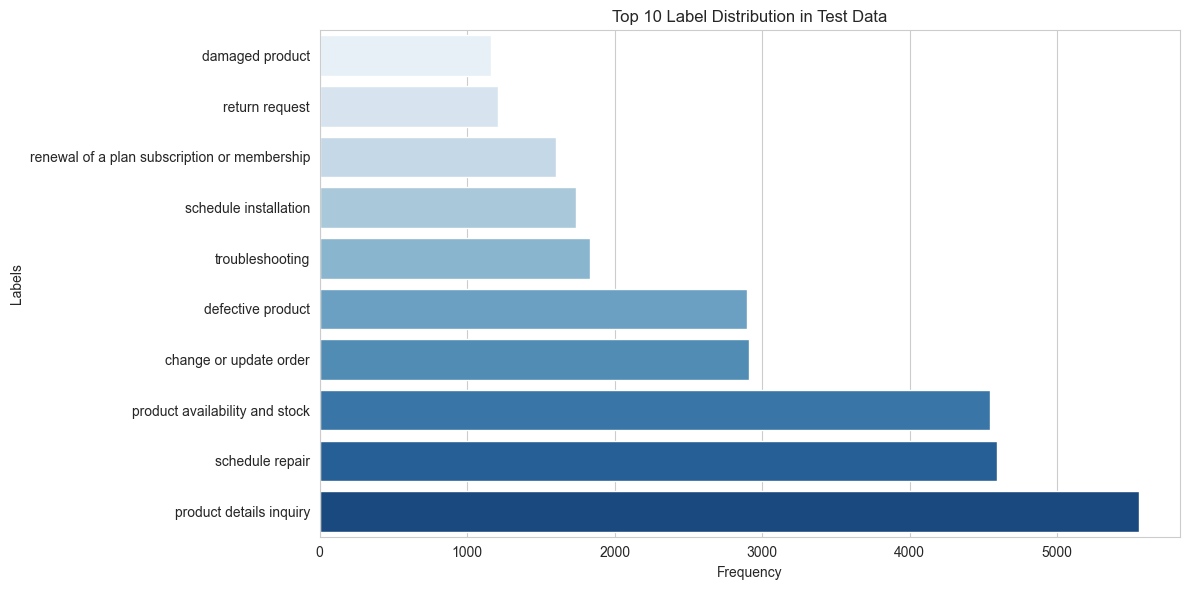

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of top labels you want to display
top_n = 10

# Calculate the value counts and keep the top 'n' labels
label_counts = test_data['predicted_label_name'].value_counts().nlargest(top_n)

# Create a more visually appealing bar chart using Seaborn
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette="Blues_r")

# Customize the chart aesthetics
ax.set(xlabel='Frequency', ylabel='Labels')
plt.title('Top 10 Label Distribution in Test Data')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability

# Add data labels to the bars
for p in ax.patches:
    width = p.get_width()
    # plt.text(width + 5, p.get_y() + p.get_height() / 2, f'{width}', ha='center', va='center')

plt.tight_layout()
plt.show()


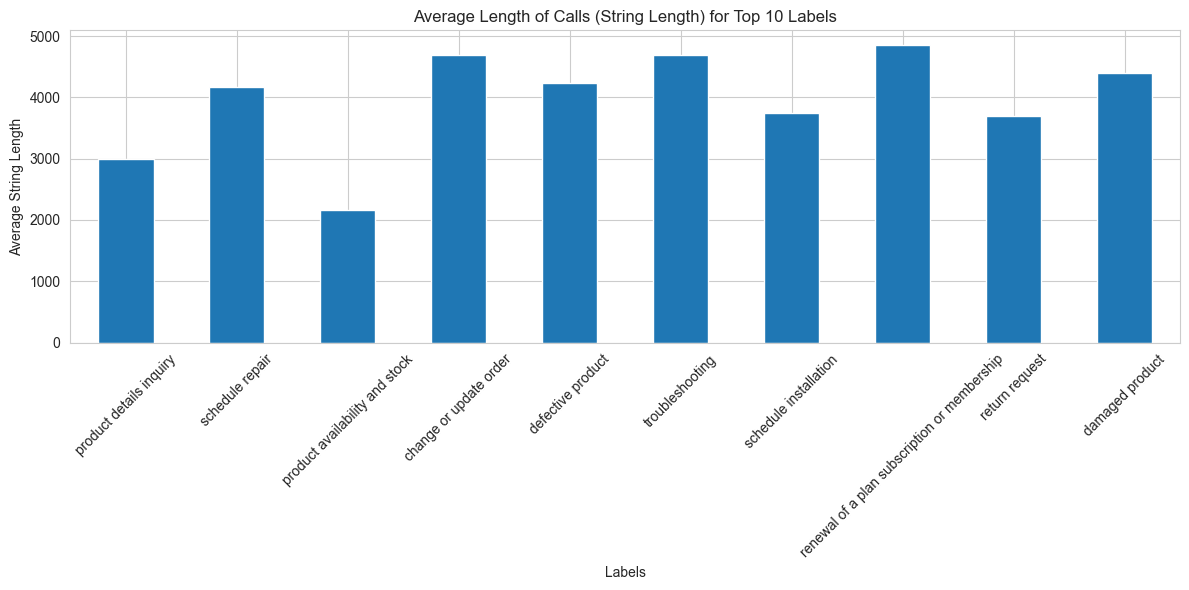

In [34]:
# Group the data by the 'label' column
label_groups = test_data.groupby('label')

# Calculate the average string length of the 'text' column for each label group
average_string_lengths = label_groups['text'].apply(lambda x: x.str.len().mean())

# Select the top 10 labels based on their frequency
top_n_labels = label_counts.index[:top_n]

# Filter the average string lengths for the top 10 labels
top_n_average_string_lengths = average_string_lengths[top_n_labels]

# Plot a bar graph for the top 10 labels and their average string lengths of cleaned text
plt.figure(figsize=(12, 6))
top_n_average_string_lengths.plot(kind='bar')
plt.title('Average Length of Calls (String Length) for Top 10 Labels')
plt.xlabel('Labels')
plt.ylabel('Average String Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

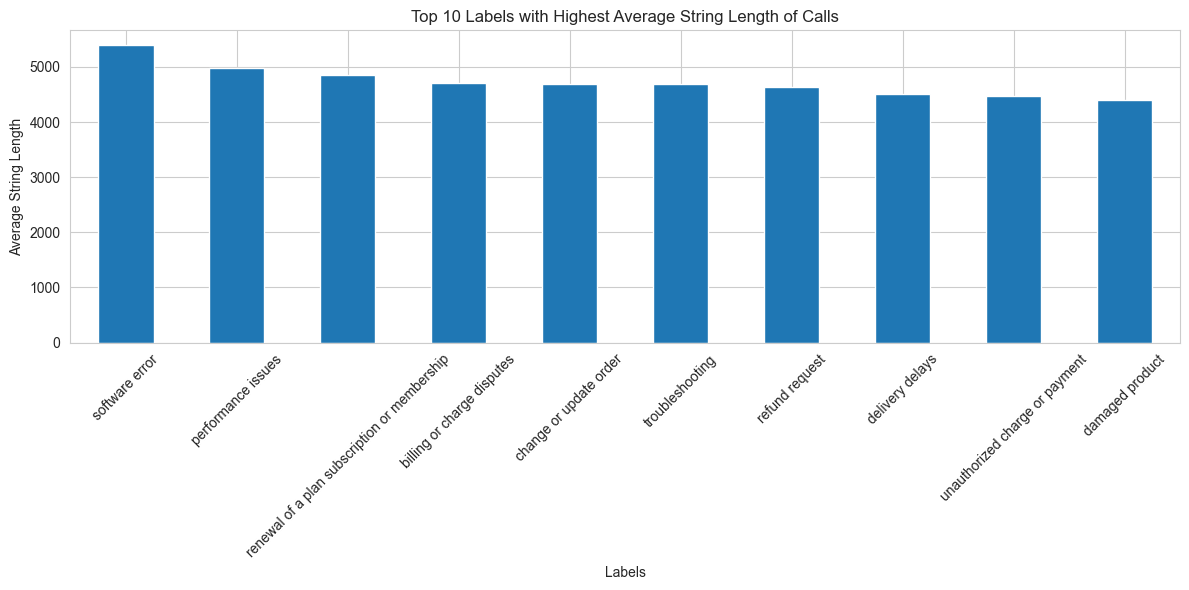

In [35]:
# Calculate the average string length of the 'text' column for each label group
average_string_lengths = label_groups['text'].apply(lambda x: x.str.len().mean())

# Sort the labels based on average string length in descending order
sorted_labels = average_string_lengths.sort_values(ascending=False)

# Select the top 10 labels with the highest average string lengths
top_10_highest_length_labels = sorted_labels[:10]

# Plot a bar graph for the top 10 labels with the highest average string lengths
plt.figure(figsize=(12, 6))
top_10_highest_length_labels.plot(kind='bar')
plt.title('Top 10 Labels with Highest Average String Length of Calls')
plt.xlabel('Labels')
plt.ylabel('Average String Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

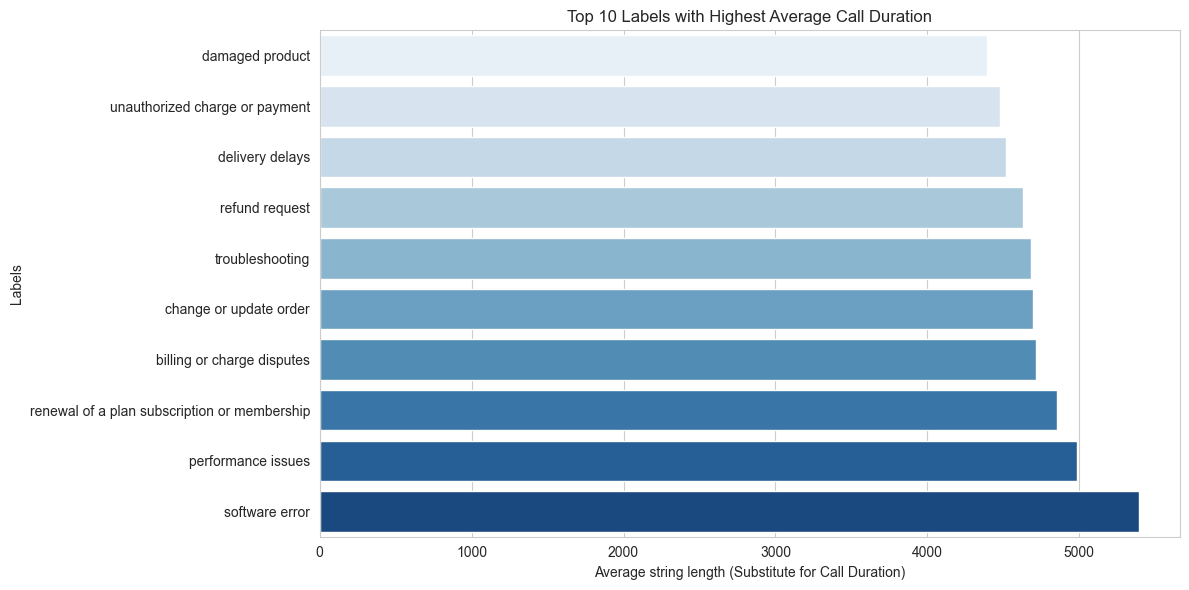

In [36]:
# Calculate the average string length of the 'text' column for each label group
average_string_lengths = label_groups['text'].apply(lambda x: x.str.len().mean())

# Sort the labels based on average string length in descending order
sorted_labels = average_string_lengths.sort_values(ascending=False)

# Select the top 10 labels with the highest average string lengths
top_10_highest_length_labels = sorted_labels[:10]

# Create a more visually appealing bar chart using Seaborn
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=top_10_highest_length_labels.values, y=top_10_highest_length_labels.index, palette="Blues_r")

# Add labels and titles
ax.set(xlabel='Average string length (Substitute for Call Duration)', ylabel='Labels')
plt.title('Top 10 Labels with Highest Average Call Duration')

# Invert the y-axis for better readability
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


Pearson's correlation coefficient: -0.133
P-value: 0.323


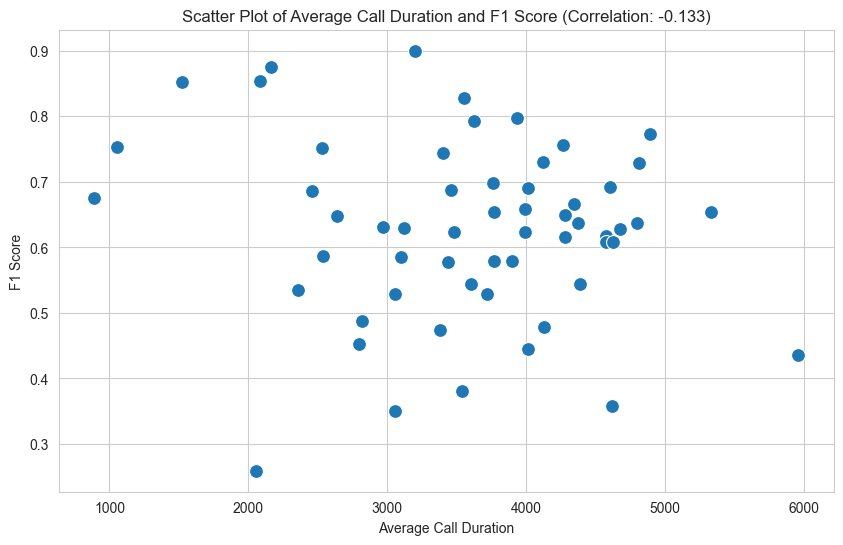

In [40]:
from scipy import stats

# Calculate the average call duration for each label
test_data['call_duration'] = test_data['text'].apply(len)
avg_call_duration_by_label = test_data.groupby('predicted_label_name')['call_duration'].mean().reset_index()

# Calculating label-wise F1 Score
label_wise_f1 = test_data.groupby('predicted_label_name').apply(
    lambda x: f1_score(x['label'], x['predicted_label_name'], average='micro')
).reset_index(name='F1 Score')

# Merge the F1 score with average call duration
label_wise_metrics = pd.merge(label_wise_f1, avg_call_duration_by_label, on='predicted_label_name')

# Calculate Pearson's correlation coefficient
correlation_coefficient, p_value = stats.pearsonr(label_wise_metrics['call_duration'], label_wise_metrics['F1 Score'])

# Output the Pearson's correlation coefficient
print(f"Pearson's correlation coefficient: {correlation_coefficient:.3f}")
print(f"P-value: {p_value:.3f}")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=label_wise_metrics, x='call_duration', y='F1 Score', s=100)
plt.title(f'Scatter Plot of Average Call Duration and F1 Score (Correlation: {correlation_coefficient:.3f})')
plt.xlabel('Average Call Duration')
plt.ylabel('F1 Score')
plt.show()

In [41]:
# SENTIMENT ANALYSIS TEXTBLOB

In [42]:
from textblob import TextBlob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Initialize tqdm for pandas apply
tqdm.pandas()

# Function to calculate sentiment polarity using TextBlob
def calculate_sentiment_textblob(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply TextBlob sentiment analysis
test_data['sentiment_polarity'] = test_data['cleaned_text'].progress_apply(calculate_sentiment_textblob)

# Classify the tone based on polarity
test_data['tone_textblob'] = test_data['sentiment_polarity'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

  0%|          | 0/47416 [00:00<?, ?it/s]

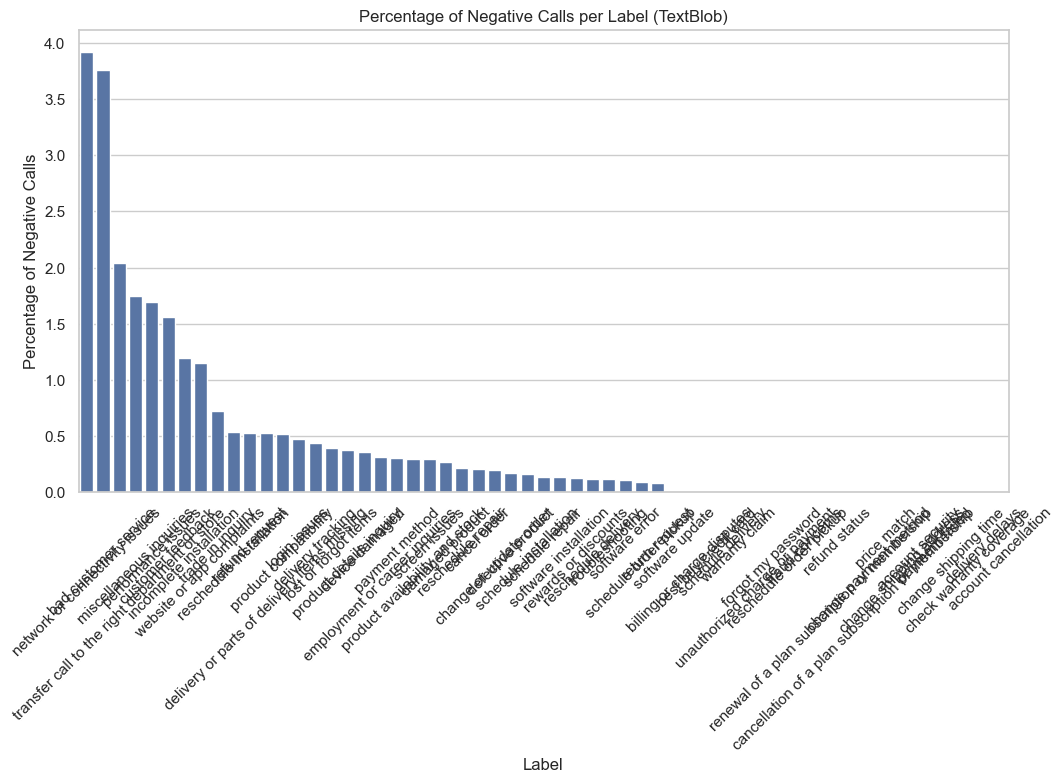

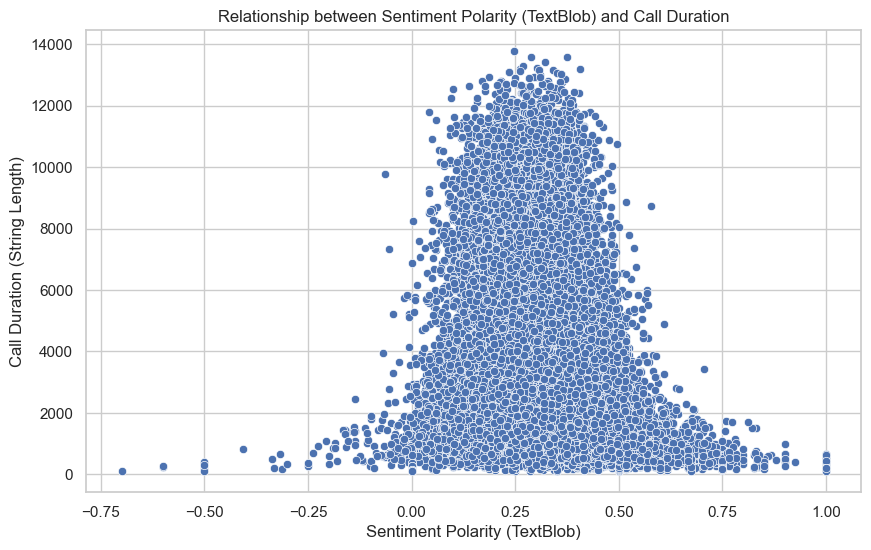

Pearson's correlation (TextBlob): -0.2331205721992449


In [43]:
def calculate_negative_percentage(df, sentiment_column, label_column):
    negative_counts = df[df[sentiment_column] == 'negative'].groupby(label_column).size()
    total_counts = df.groupby(label_column).size()
    negative_percentage = (negative_counts / total_counts) * 100
    negative_percentage = negative_percentage.fillna(0)  # Fill NaN values with 0
    return negative_percentage.sort_values(ascending=False)

# Calculate the percentage of negative calls using TextBlob results
negative_percentage_textblob = calculate_negative_percentage(test_data, 'tone_textblob', 'label')

# Plotting the percentage of negative calls per label (TextBlob)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=negative_percentage_textblob.index, y=negative_percentage_textblob.values)
plt.title('Percentage of Negative Calls per Label (TextBlob)')
plt.xlabel('Label')
plt.ylabel('Percentage of Negative Calls')
plt.xticks(rotation=45)
plt.show()

# Calculate string length as a proxy for call duration
test_data['string_length'] = test_data['text'].apply(len)

# Scatter plot and correlation for TextBlob sentiment polarity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_polarity', y='string_length', data=test_data)
plt.title('Relationship between Sentiment Polarity (TextBlob) and Call Duration')
plt.xlabel('Sentiment Polarity (TextBlob)')
plt.ylabel('Call Duration (String Length)')
plt.show()

# Calculate Pearson's correlation
correlation_textblob, p_value_textblob = stats.pearsonr(test_data['sentiment_polarity'], test_data['string_length'])
print(f"Pearson's correlation (TextBlob): {correlation_textblob}")

In [44]:
# Display the first few rows of the DataFrame
print(test_data.head(5))

                                                text  \
0  agent says thanks for contacting geek squad. m...   
1  agent says thank you for choosing miss pice my...   
2  agent says best buy this is name. may i get th...   
3  agent says hello thank you for calling best bu...   
4  agent says hi this is ribbie with best buy dat...   

                            label  \
0  product availability and stock   
1            bad customer service   
2         product details inquiry   
3                 schedule repair   
4         product details inquiry   

                                        cleaned_text  predicted_label  \
0  thanks contacting geek squad name get started ...               31   
1  thank choosing miss pice name name help date b...                2   
2  best buy name may get complete name phone numb...               33   
3  hello thank calling best buy name name get sta...               46   
4  hi ribbie best buy date name phone number plea...               33   

 

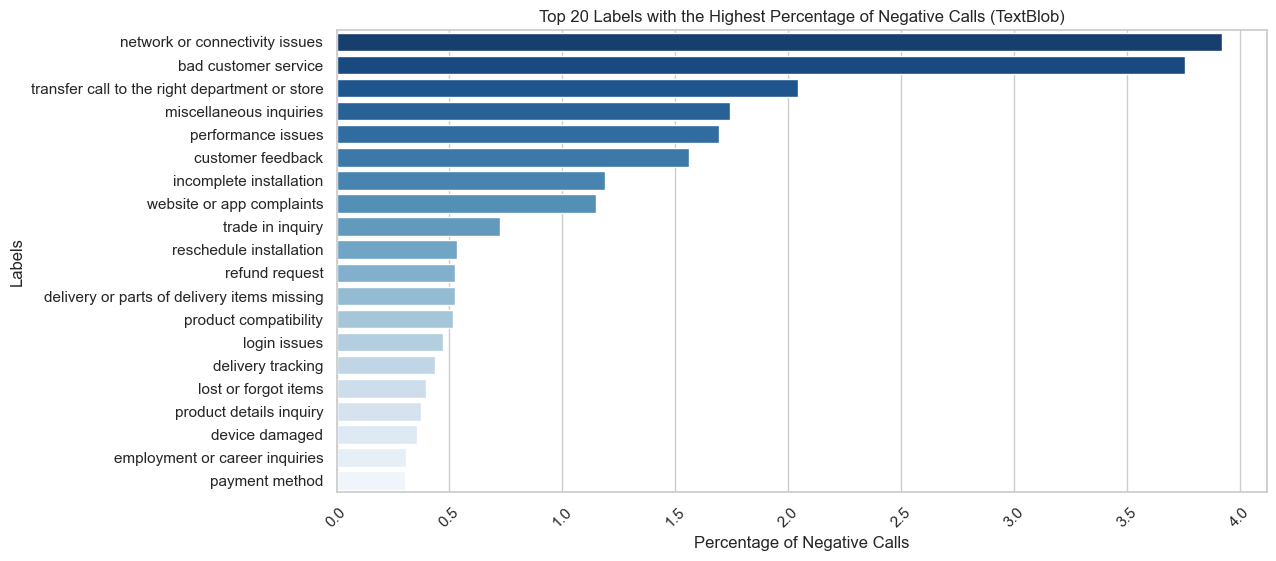

In [45]:
# Calculate the percentage of negative calls using TextBlob results
negative_percentage_textblob = calculate_negative_percentage(test_data, 'tone_textblob', 'label')

# Get the top 20 labels with the highest percentage of negative calls
top_20_labels_negative_percentage = negative_percentage_textblob.nlargest(20)

# Plotting the top 20 labels with the highest percentage of negative calls (TextBlob)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
# Ensure that the data is sorted correctly here before plotting
sns.barplot(x=top_20_labels_negative_percentage.values, y=top_20_labels_negative_percentage.index, palette="Blues_r")

plt.title('Top 20 Labels with the Highest Percentage of Negative Calls (TextBlob)')
plt.xlabel('Percentage of Negative Calls')
plt.ylabel('Labels')
plt.xticks(rotation=45)  # Rotate the x-labels if necessary
plt.show()

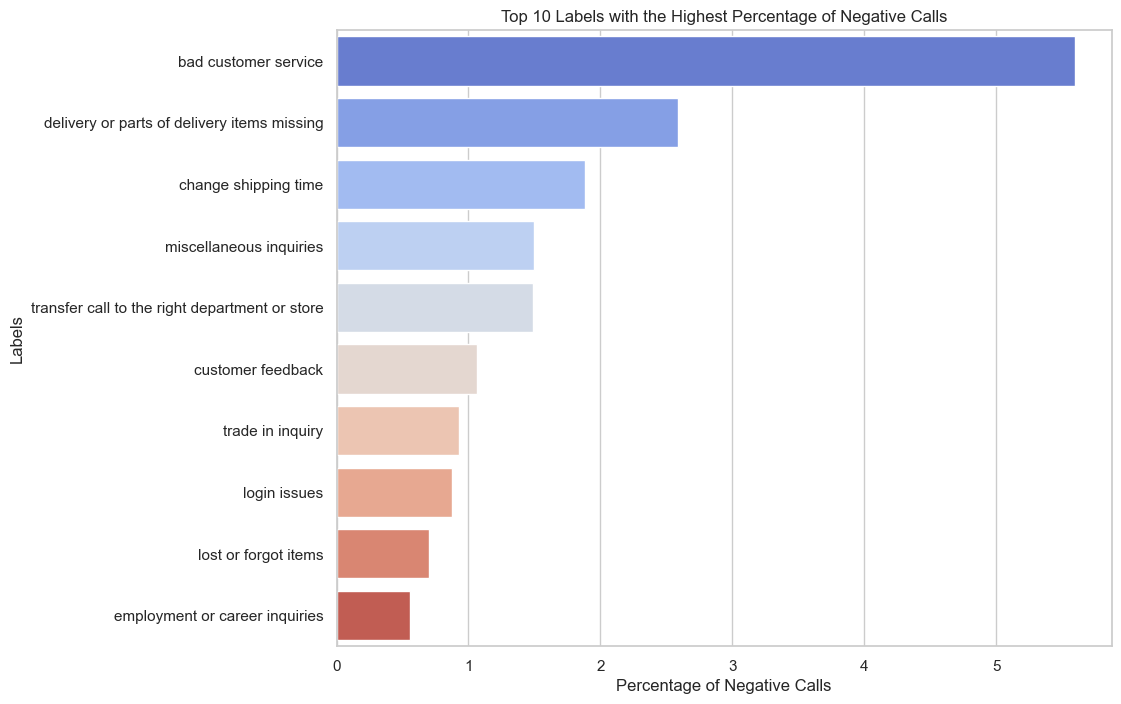

In [46]:
# calculate the percentage of negative calls for each label
negative_counts = test_data[test_data['tone_textblob'] == 'negative']['predicted_label_name'].value_counts()
total_counts = test_data['predicted_label_name'].value_counts()
negative_percentage = (negative_counts / total_counts * 100).sort_values(ascending=False)

# select the top 10 labels with the highest percentage of negative calls
top_10_negative_percentage = negative_percentage.head(10)

# Plotting the top 10 labels with the highest percentage of negative calls
plt.figure(figsize=(10, 8))
sns.barplot(y=top_10_negative_percentage.index, x=top_10_negative_percentage.values, palette="coolwarm", orient='h')
plt.title('Top 10 Labels with the Highest Percentage of Negative Calls')
plt.xlabel('Percentage of Negative Calls')
plt.ylabel('Labels')
plt.show()

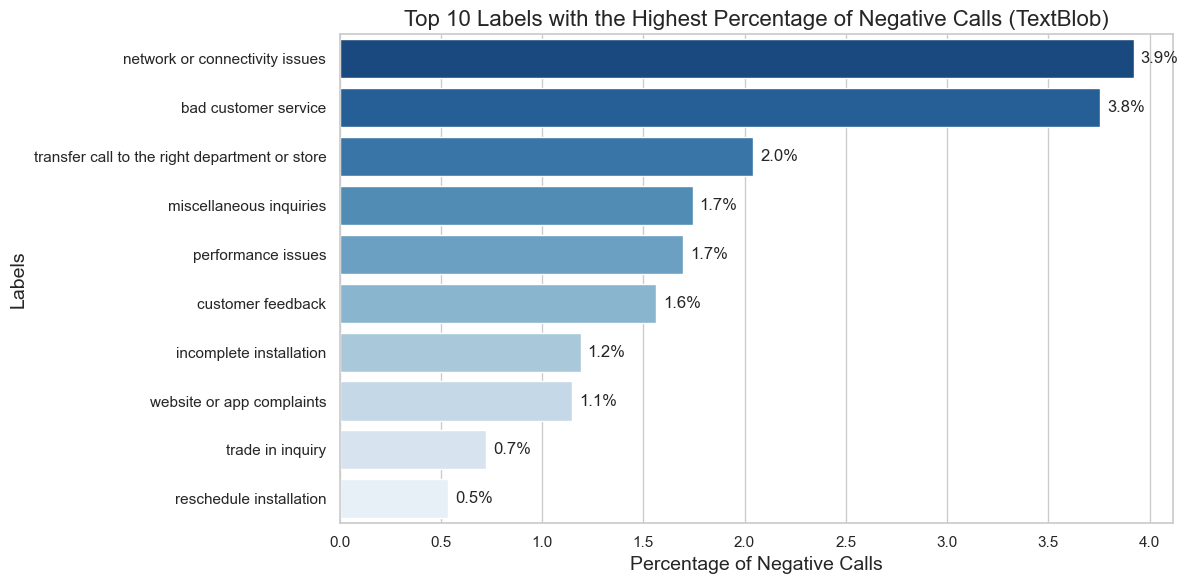

In [47]:
# Calculate the percentage of negative calls using TextBlob results
negative_percentage_textblob = calculate_negative_percentage(test_data, 'tone_textblob', 'label')

# Get the top 10 labels with the highest percentage of negative calls
top_10_labels_negative_percentage = negative_percentage_textblob.nlargest(10)

# Plotting the top 10 labels with the highest percentage of negative calls (TextBlob)
plt.figure(figsize=(12, 6))
ax = sns.barplot(y=top_10_labels_negative_percentage.index, x=top_10_labels_negative_percentage.values, palette="Blues_r")
ax.set_title('Top 10 Labels with the Highest Percentage of Negative Calls (TextBlob)', fontsize=16)
ax.set_xlabel('Percentage of Negative Calls', fontsize=14)
ax.set_ylabel('Labels', fontsize=14)
# Adding the percentage values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}%', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha = 'left', va = 'center', 
                size=12, xytext = (5, 0), 
                textcoords = 'offset points')
plt.tight_layout()
plt.show()

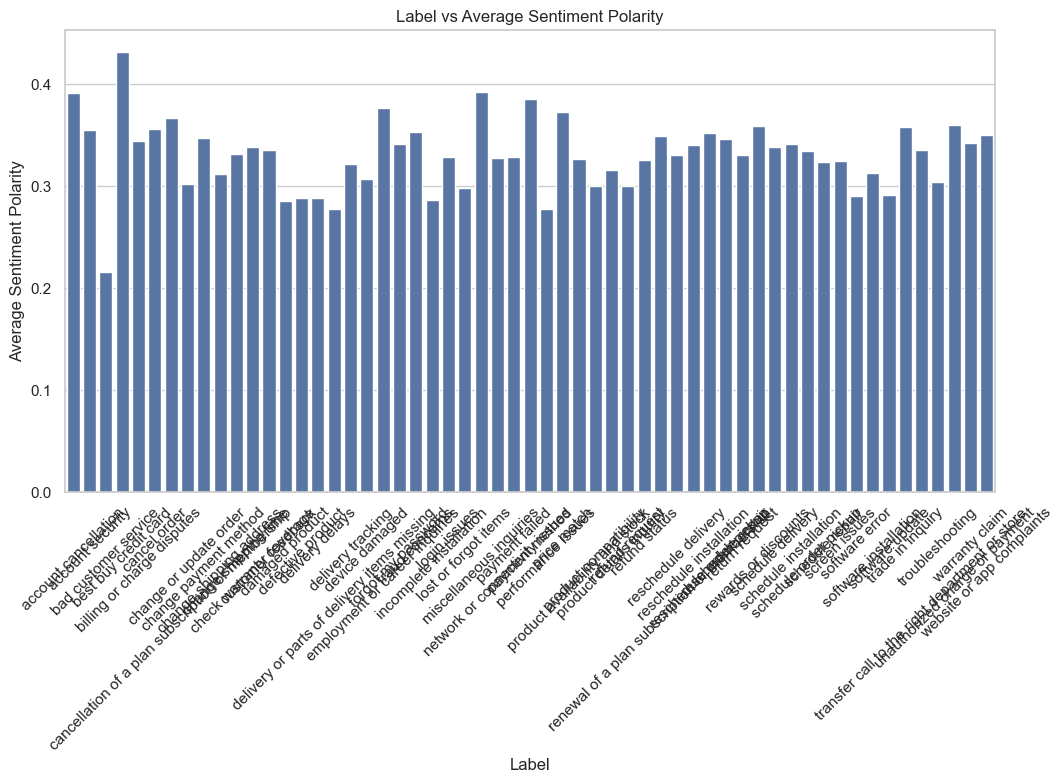

In [48]:
# Calculate the average sentiment polarity for each label
avg_polarity_by_label = test_data.groupby('predicted_label_name')['sentiment_polarity'].mean()

# Plot label vs average sentiment polarity
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_polarity_by_label.index, y=avg_polarity_by_label.values)
plt.title('Label vs Average Sentiment Polarity')
plt.xlabel('Label')
plt.ylabel('Average Sentiment Polarity')
plt.xticks(rotation=45)
plt.show()

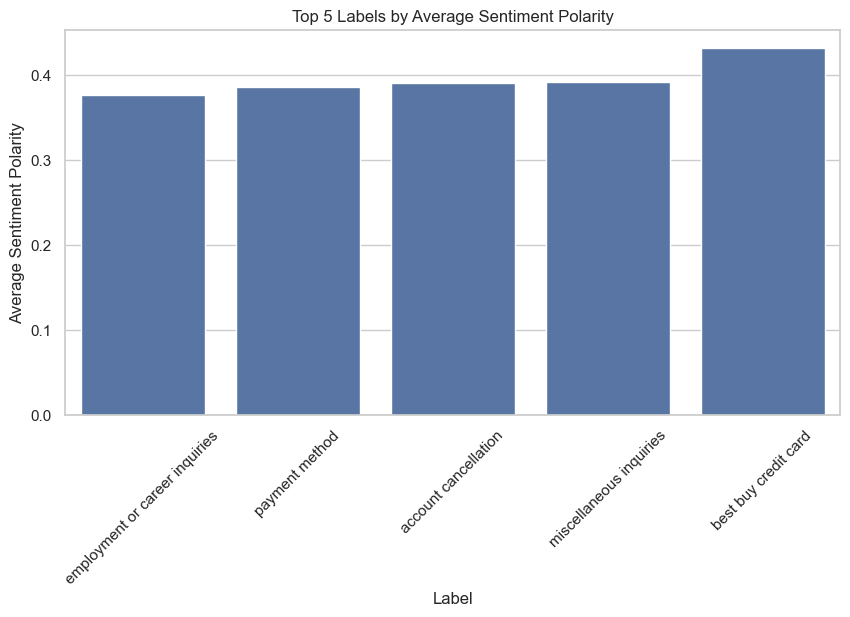

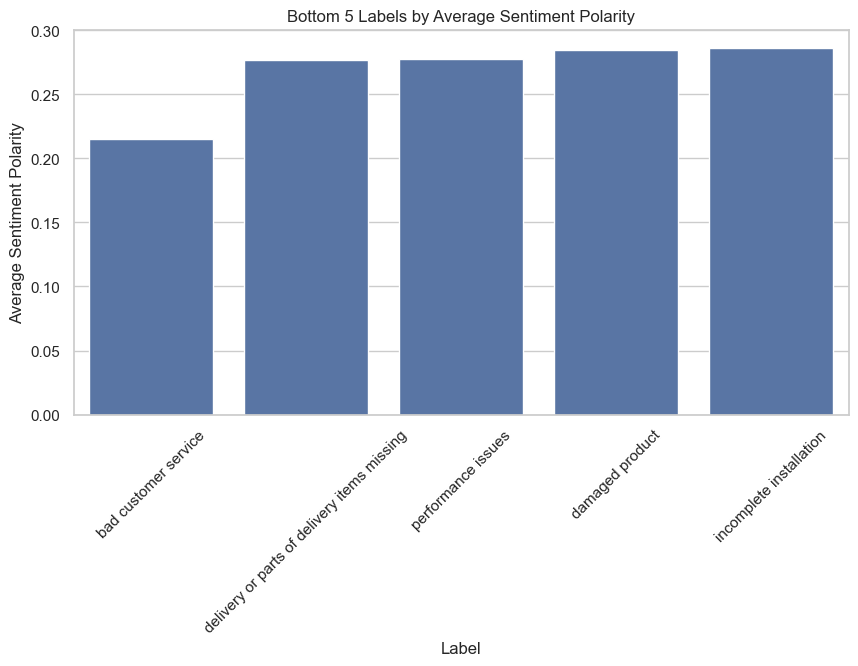

In [49]:
# Calculate the average sentiment polarity for each label
avg_polarity_by_label = test_data.groupby('predicted_label_name')['sentiment_polarity'].mean().sort_values()

# Select the top 5 labels with the highest average sentiment polarity
top_5_polarity_labels = avg_polarity_by_label.tail(5)

# Select the bottom 5 labels with the lowest average sentiment polarity
bottom_5_polarity_labels = avg_polarity_by_label.head(5)

# Plot the top 5 labels with the highest average sentiment polarity
plt.figure(figsize=(10, 5))
sns.barplot(x=top_5_polarity_labels.index, y=top_5_polarity_labels.values)
plt.title('Top 5 Labels by Average Sentiment Polarity')
plt.xlabel('Label')
plt.ylabel('Average Sentiment Polarity')
plt.xticks(rotation=45)
plt.show()

# Plot the bottom 5 labels with the lowest average sentiment polarity
plt.figure(figsize=(10, 5))
sns.barplot(x=bottom_5_polarity_labels.index, y=bottom_5_polarity_labels.values)
plt.title('Bottom 5 Labels by Average Sentiment Polarity')
plt.xlabel('Label')
plt.ylabel('Average Sentiment Polarity')
plt.xticks(rotation=45)
plt.show()


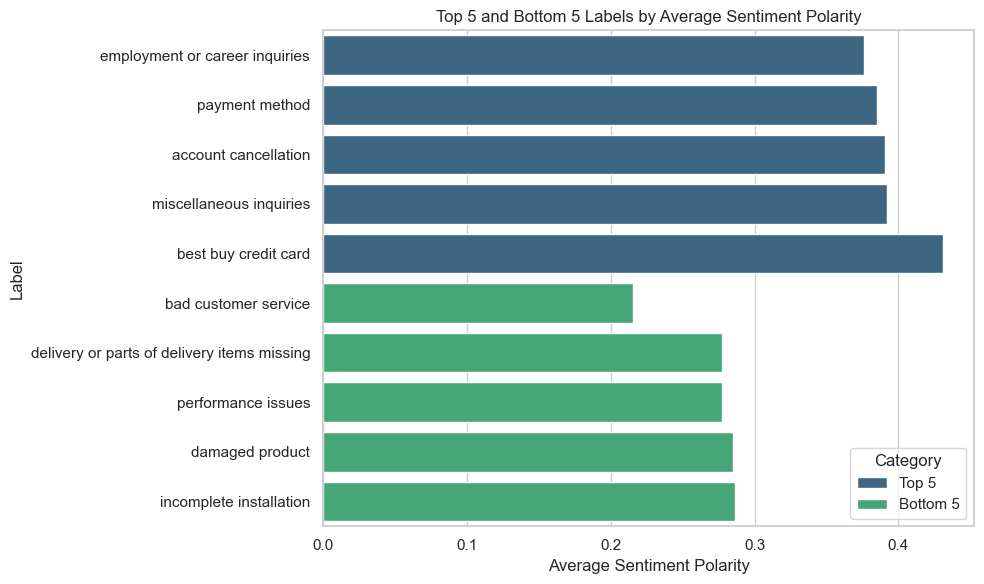

In [51]:
# Calculate the average sentiment polarity for each label
avg_polarity_by_label = test_data.groupby('predicted_label_name')['sentiment_polarity'].mean().sort_values()

# Select the top 5 labels with the highest average sentiment polarity
top_5_polarity_labels = avg_polarity_by_label.tail(5)

# Select the bottom 5 labels with the lowest average sentiment polarity
bottom_5_polarity_labels = avg_polarity_by_label.head(5)

# Combine top 5 and bottom 5 into a single DataFrame
combined_polarity = pd.concat([top_5_polarity_labels, bottom_5_polarity_labels]).reset_index()
combined_polarity.columns = ['Label', 'Average Sentiment Polarity']

# Mark each row as either 'Top 5' or 'Bottom 5'
combined_polarity['Category'] = ['Top 5' if label in top_5_polarity_labels.index else 'Bottom 5' 
                                for label in combined_polarity['Label']]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_polarity, y='Label', x='Average Sentiment Polarity', hue='Category', palette='viridis', orient='h')
plt.title('Top 5 and Bottom 5 Labels by Average Sentiment Polarity')
plt.ylabel('Label')
plt.xlabel('Average Sentiment Polarity')
plt.legend(title='Category', loc='lower right')
plt.tight_layout()
plt.show()


In [52]:
# Export to Excel
test_data.to_excel('test_data_predictions_v1.0.xlsx', index=False) 